# Gender Bias in Multilingual Embeddings

This notebook is for the intrinsic bias analysis. For extrinsic bias analysis, please refer to the "Extrinsic Bias Analysis" section in our paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import os
import random
random.seed(2)
import scipy
from collections import defaultdict
import tqdm
from matplotlib import pyplot as plt

 We adopt the WE class from [here](https://github.com/tolga-b/debiaswe)

In [3]:
import sys
sys.path.insert(0, "/home/jyzhao/Github/debiaswe/debiaswe")
import we

In [4]:
def sim(E, x, y):
    return 1 - scipy.spatial.distance.cosine(E.v(x), E.v(y))

def dis(E, x, y):
    return scipy.spatial.distance.cosine(E.v(x), E.v(y))

def sim_v(u, v):
    return 1 - scipy.spatial.distance.cosine(u, v)

In [5]:
def cal_bias_paired(E, paired_m, paired_f, gender_def_pairs):
    assert len(paired_m) == len(paired_f) 
    O, M, F = [], [], []
    
    for idx in range(len(paired_m)):
        overall = np.average([abs(dis(E, paired_m[idx], m) - dis(E, paired_f[idx], f))\
                             for f,m in gender_def_pairs])
        O.append(overall) 
    return O, np.average(O)

In [6]:
#read occ list from other languages. format: en-occ es-occ
def read_occs(f_file, m_file, E):
    occ_def_f_raw = []
    occ_def_m_raw = []
    with open(f_file, 'r') as es_f, open(m_file, 'r') as es_m:
        for line in es_f.readlines():
            tokens = line.strip().split('\t')
            if tokens[0].lower() not in en_occ_def_f:
                print("wrong line:", tokens)
                break
            occ_def_f_raw.append(tokens[1].lower())
        for line in es_m.readlines():
            tokens = line.strip().split('\t')
            if tokens[0].lower() not in en_occ_def_m:
                print("wrong line:", tokens)
                break
            occ_def_m_raw.append(tokens[1].lower())

    print(len(occ_def_m_raw), len(occ_def_f_raw))    
    ids = []
    for idx in range(len(occ_def_f_raw)):
        if occ_def_f_raw[idx]  in E.words and occ_def_m_raw[idx]  in E.words:
            ids.append(idx)
    print(f'{len(ids)} pairs in the embeddings')
    occ_def_f = [occ_def_f_raw[x] for x in ids]
    occ_def_m = [occ_def_m_raw[x] for x in ids]
    return occ_def_f, occ_def_m

# 1. inBias in English

#### - Read embeddings
  Generate a debiased EN from [here](https://github.com/tolga-b/debiaswe)

In [13]:
en_ori_file = '/home/jyzhao/git7/fastText/alignment/data/wiki.en.vec'
en_debiased_file = '/home/jyzhao/git7/fastText/alignment/data/wiki.en_debias.vec'
en_sup_es_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.en-es.vec' #fasttext EN-->Es
en_sup_de_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.en-de.vec' #fasttext EN-->de
en_sup_fr_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.en-fr.vec' 
en_sup_tr_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.en-tr.vec'

In [6]:
gender_definitions_files = 'inBias/en_gender_pairs.json'
gender_pairs = json.load(open(gender_definitions_files, 'r'))
gender_pairs = [[x.lower(), y.lower()] for x,y in gender_pairs]

In [16]:
#read original EN
en_ori_E = we.WordEmbedding(en_ori_file)
#gender direction 
en_ori_gd = we.doPCA(gender_pairs, en_ori_E).components_[0] 

0it [00:00, ?it/s]

*** Reading data from /home/jyzhao/git7/fastText/alignment/data/wiki.en.vec
2519370 vocabs; 300 dimensions


2519370it [11:11, 3749.08it/s]


(2519370, 300)
2519370 words of dimension 300 : ,, ., the, </s>, ..., ukihashi, draw_lax, style—but, korpaljo
2519370 words of dimension 300 : ,, ., the, </s>, ..., ukihashi, draw_lax, style—but, korpaljo


In [ ]:
#reading debiased EN
en_deb_E = we.WordEmbedding(en_debiased_file)
en_deb_gd = we.doPCA(gender_pairs, en_deb_E).components_[0]

In [ ]:
#read EN-ES
en_sup_es_E = we.WordEmbedding(en_sup_es_file)
en_sup_es_gd = we.doPCA(gender_pairs, en_sup_es_E).components_[0]

In [ ]:
#read EN-DE
en_sup_de_E = we.WordEmbedding(en_sup_de_file)
en_sup_de_gd = we.doPCA(gender_pairs, en_sup_de_E).components_[0]

In [ ]:
#read EN-FR
en_sup_fr_E = we.WordEmbedding(en_sup_fr_file)
en_sup_fr_gd = we.doPCA(gender_pairs, en_sup_fr_E).components_[0]

In [ ]:
#read EN-TR
en_sup_tr_E = we.WordEmbedding(en_sup_tr_file)
en_sup_tr_gd = we.doPCA(gender_pairs, en_sup_tr_E).components_[0]


#### - Read masculine/feminine occupations. The occupation lists are adopted from [Learning Gender-Neutral Word Embeddings](https://github.com/uclanlp/gn_glove) and extended by us. 

In [26]:
vocab = en_ori_E.words

In [12]:
en_occ_def_f_raw = [x.strip().split('\t')[0] for x in open('inBias/en_female_def_occ').readlines()]
en_occ_def_m_raw = [x.strip().split('\t')[0] for x in open('inBias/en_male_def_occ').readlines()]

In [42]:
#make sure both feminine and masculine versions are in the vocab
ids = []
for x in range(len(en_occ_def_m_raw)):
    if en_occ_def_f_raw[x] in vocab and en_occ_def_m_raw[x] in vocab:
        ids.append(x)  
    else:
        print(x)
en_occ_def_f = [en_occ_def_f_raw[x] for x in ids]
en_occ_def_m = [en_occ_def_m_raw[x] for x in ids]

- **inBias score in EN-xx embeddings**

In [52]:
#Using paired English occupations such as actor/actress
O_en_ori_p, O = cal_bias_paired(en_ori_E, en_occ_def_m[:137], en_occ_def_f[:137], gender_pairs)
print(f"in original EN, average bias in strong gendered words:{O}")
O_en_ori_s, O = cal_bias_paired(en_ori_E, en_occ_def_m[137:], en_occ_def_f[137:], gender_pairs)
print(f"in original EN, average bias in weak gendered words:{O}")
O_en_ori, O = cal_bias_paired(en_ori_E, en_occ_def_m, en_occ_def_f, gender_pairs)
print(f"in original EN, average bias across all occupation words:{O}")

in original EN, average bias in strong gendered words:0.113837761300656
in original EN, average bias in weak gendered words:0.047707567879007436
in original EN, average bias across all occupation words:0.08295984997537262


In [53]:
O_en_sup_es_p, O = cal_bias_paired(en_sup_es_E, en_occ_def_m[:137], en_occ_def_f[:137], gender_pairs)
print(f"in EN-ES, average bias in strong gendered words:{O}")
O_en_sup_es_s, O,  = cal_bias_paired(en_sup_es_E, en_occ_def_m[137:], en_occ_def_f[137:], gender_pairs)
print(f"in EN-ES, average bias in weak gendered words:{O}")
O_en_sup_es, O  = cal_bias_paired(en_sup_es_E, en_occ_def_m, en_occ_def_f, gender_pairs)
print(f"in EN-ES, average bias:{O}")

in EN-ES, average bias in strong gendered words:0.08481298356233141
in EN-ES, average bias in weak gendered words:0.040029569166815944
in EN-ES, average bias:0.06390243987570941


In [33]:
scipy.stats.ttest_ind(O_en_ori, O_en_sup_es)

Ttest_indResult(statistic=4.906336461890209, pvalue=1.2488050530237517e-06)

In [34]:
scipy.stats.ttest_ind(O_en_ori_p, O_en_sup_es_p)

Ttest_indResult(statistic=5.705271952879427, pvalue=3.028436192227244e-08)

In [35]:
O_en_sup_de_p, O = cal_bias_paired(en_sup_de_E, en_occ_def_m[:137], en_occ_def_f[:137],gender_pairs)
print(f"in DE-EN, average bias:{O}")
O_en_sup_de_s, O = cal_bias_paired(en_sup_de_E, en_occ_def_m[137:], en_occ_def_f[137:], gender_pairs)
print(f"in DE-EN, average bias:{O}")
O_en_sup_de, O  = cal_bias_paired(en_sup_de_E, en_occ_def_m, en_occ_def_f, gender_pairs)
print(f"in DE-EN, average bias:{O}")

in DE-EN, average bias:0.0934872714574513
in DE-EN, average bias:0.043027333163276865
in DE-EN, average bias:0.06992621077534651


In [36]:
scipy.stats.ttest_ind(O_en_ori, O_en_sup_de), scipy.stats.ttest_ind(O_en_ori_p, O_en_sup_de_p)

(Ttest_indResult(statistic=3.241942332987269, pvalue=0.001264507059230683),
 Ttest_indResult(statistic=3.8952743315311618, pvalue=0.00012352672682877826))

In [37]:
O_en_sup_fr_p, O = cal_bias_paired(en_sup_fr_E, en_occ_def_m[:137], en_occ_def_f[:137],gender_pairs)
print(f"in FR-EN, average bias:{O}")
O_en_sup_fr_s, O, = cal_bias_paired(en_sup_fr_E, en_occ_def_m[137:], en_occ_def_f[137:], gender_pairs)
print(f"in FR-EN, average bias:{O} ")
O_en_sup_fr, O = cal_bias_paired(en_sup_fr_E, en_occ_def_m, en_occ_def_f, gender_pairs)
print(f"in FR-EN, average bias:{O} ")

in FR-EN, average bias:0.08329827981394476
in FR-EN, average bias:0.03947033618611318 
in FR-EN, average bias:0.06283387033791445 


In [38]:
scipy.stats.ttest_ind(O_en_ori, O_en_sup_fr), scipy.stats.ttest_ind(O_en_ori_p, O_en_sup_fr_p)

(Ttest_indResult(statistic=5.175336971540256, pvalue=3.2727527122779993e-07),
 Ttest_indResult(statistic=5.986697194534606, pvalue=6.745202310216384e-09))

In [39]:
O_en_sup_tr, O = cal_bias_paired(en_sup_tr_E, en_occ_def_m, en_occ_def_f,  gender_pairs)
print(f"in tr-aligned EN, average bias:{O}")

in tr-aligned EN, average bias:0.059185084214831034


## - Bias in ENDEB

In [40]:
O_en_deb_p, O = cal_bias_paired(en_deb_E, en_occ_def_m[:137], en_occ_def_f[:137], gender_pairs)
print(f"in debiased EN, average bias:{O}")
O_en_deb_s, O = cal_bias_paired(en_deb_E, en_occ_def_m[137:], en_occ_def_f[137:],  gender_pairs)
print(f"in debiased EN, average bias:{O}")
O_en_deb, O = cal_bias_paired(en_deb_E, en_occ_def_m, en_occ_def_f,  gender_pairs)
print(f"in debiased EN, average bias:{O}")

in debiased EN, average bias:0.08297640271635917
in debiased EN, average bias:0.01260097629791643
in debiased EN, average bias:0.05011628143148319


In [44]:
endeb_sup_es_file = '/local/jyzhao/Github/fastText/alignment/res/wiki.endeb-es.vec' #fasttext EN-->Es
endeb_sup_de_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.endeb-de.vec' #fasttext EN-->de
endeb_sup_fr_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.endeb-fr.vec' 

In [ ]:
endeb_sup_es_E = we.WordEmbedding(endeb_sup_es_file)
endeb_sup_de_E = we.WordEmbedding(endeb_sup_de_file)
endeb_sup_fr_E = we.WordEmbedding(endeb_sup_fr_file)

In [46]:
O_endeb_es_p, O = cal_bias_paired(endeb_sup_es_E, en_occ_def_m[:137], en_occ_def_f[:137], gender_pairs)
print(f"in ENDEB-ES, average bias for strong gendered words:{O}")
O_endeb_es_s, O = cal_bias_paired(endeb_sup_es_E, en_occ_def_m[137:], en_occ_def_f[137:], gender_pairs)
print(f"in ENDEB-ES, average bias for weak gendered words:{O}")
O_endeb_es, O = cal_bias_paired(endeb_sup_es_E, en_occ_def_m, en_occ_def_f, gender_pairs)
print(f"in ENDEB-ES, average bias:{O}")

in ENDEB-ES, average bias for strong gendered words:0.06830389713694772
in ENDEB-ES, average bias for weak gendered words:0.020136128379790872
in ENDEB-ES, average bias:0.04581311016862546


In [47]:
O_endeb_de_p, O= cal_bias_paired(endeb_sup_de_E, en_occ_def_m[:137], en_occ_def_f[:137], gender_pairs)
print(f"in ENDEB-DE, average bias for strong gendered words:{O}, ")
O_endeb_de_s, O = cal_bias_paired(endeb_sup_de_E, en_occ_def_m[137:], en_occ_def_f[137:], gender_pairs)
print(f"in ENDEB-DE, average bias for weak gendered words:{O}, ")
O_endeb_de, O = cal_bias_paired(endeb_sup_de_E, en_occ_def_m, en_occ_def_f, gender_pairs)
print(f"in ENDEB-DE, average bias:{O},  ")

in ENDEB-DE, average bias for strong gendered words:0.07469259366235981, 
in ENDEB-DE, average bias for weak gendered words:0.02694967444986105, 
in ENDEB-DE, average bias:0.05240018002228257,  


In [49]:
O_endeb_fr_p, O  = cal_bias_paired(endeb_sup_fr_E, en_occ_def_m[:137], en_occ_def_f[:137], gender_pairs)
print(f"in FR-ENDEB, average bias for strong gendered words:{O} ")
O_endeb_fr_s, O  = cal_bias_paired(endeb_sup_fr_E, en_occ_def_m[137:], en_occ_def_f[137:], gender_pairs)
print(f"in FR-ENDEB, average bias for weak gendered words:{O} ")
O_endeb_fr, O = cal_bias_paired(endeb_sup_fr_E, en_occ_def_m, en_occ_def_f, gender_pairs)
print(f"in FR-ENDEB, average bias:{O} ")

in FR-ENDEB, average bias for strong gendered words:0.06851245712455656 
in FR-ENDEB, average bias for weak gendered words:0.016227787953835948 
in FR-ENDEB, average bias:0.04409938202538741 


In [50]:
scipy.stats.ttest_ind(O_en_ori, O_en_deb), \
scipy.stats.ttest_ind(O_en_ori, O_endeb_es),\
scipy.stats.ttest_ind(O_en_ori, O_endeb_de), \
scipy.stats.ttest_ind(O_en_ori, O_endeb_fr)

(Ttest_indResult(statistic=7.274914900238362, pvalue=1.309257920907468e-12),
 Ttest_indResult(statistic=9.568202550651037, pvalue=4.596640811617006e-20),
 Ttest_indResult(statistic=7.4628058708328995, pvalue=3.6622724157040465e-13),
 Ttest_indResult(statistic=9.799839593791644, pvalue=6.768611519109361e-21))

----
# 2. inBias in ES

In [56]:
es_ori_file = '/home/jyzhao/git7/fastText/alignment/data/wiki.es.vec'
es_ali_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.es.align.vec'
es_sup_de_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.es-de.vec'
es_sup_fr_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.es-fr.vec'
es_sup_endeb_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.es-endeb.vec'

In [ ]:
es_ori_E = we.WordEmbedding(es_ori_file)
es_sup_endeb_E = we.WordEmbedding(es_sup_endeb_file)
es_ali_E = we.WordEmbedding(es_ali_file)
es_sup_de_E = we.WordEmbedding(es_sup_de_file)
es_sup_fr_E = we.WordEmbedding(es_sup_fr_file)

In [59]:
es_gender_pairs = json.load(open('inBias/es_gender_pairs.json', 'r'))

In [62]:
es_ori_gd = we.doPCA(es_gender_pairs, es_ori_E).components_[0]
es_ali_gd = we.doPCA(es_gender_pairs, es_ali_E).components_[0]
es_sup_endeb_gd = we.doPCA(es_gender_pairs, es_sup_endeb_E).components_[0]
es_sup_de_gd = we.doPCA(es_gender_pairs, es_sup_de_E).components_[0]
es_sup_fr_gd = we.doPCA(es_gender_pairs, es_sup_fr_E).components_[0]

- Read the occupation list for ES
The list is translated from EN.

In [64]:
es_occ_def_f, es_occ_def_m = read_occs('inBias/es_female_def_occ', 'inBias/es_male_def_occ', es_ori_E)

257 257
251 pairs in the embeddings


- #### inBias score changes

In [67]:
o_es_ori, o = cal_bias_paired(es_ori_E,  es_occ_def_m, es_occ_def_f, es_gender_pairs)
print(f"in original ES, average bias:{o}")

o_es_ali, o = cal_bias_paired(es_ali_E, es_occ_def_m, es_occ_def_f, es_gender_pairs)
print(f"in ES-EN, average bias:{o}")

o_es_sup_de, o = cal_bias_paired(es_sup_de_E,es_occ_def_m, es_occ_def_f,es_gender_pairs)
print(f"in ES-DE, average bias:{o}")

o_es_sup_fr, o = cal_bias_paired(es_sup_fr_E,es_occ_def_m, es_occ_def_f,  es_gender_pairs)
print(f"in ES-FR, average bias:{o}")

o_es_sup_endeb, o, = cal_bias_paired(es_sup_endeb_E, es_occ_def_m, es_occ_def_f, es_gender_pairs)
print(f"in ES-ENDEB, average bias:{o}")

in original ES, average bias:0.08032530358274752
in ES-EN, average bias:0.08891596550644666
in ES-DE, average bias:0.06340341033160872
in ES-FR, average bias:0.06417109799786128
in ES-ENDEB, average bias:0.06649101964532406


In [68]:
scipy.stats.ttest_ind(o_es_ori, o_es_ali)

Ttest_indResult(statistic=-2.040347658109655, pvalue=0.04184055027641032)

In [69]:
scipy.stats.ttest_ind(o_es_ori, o_es_sup_de)

Ttest_indResult(statistic=4.961198471930474, pvalue=9.618954015293024e-07)

In [70]:
scipy.stats.ttest_ind(o_es_ori, o_es_sup_fr)

Ttest_indResult(statistic=4.3013699906592615, pvalue=2.042143354674492e-05)

In [71]:
scipy.stats.ttest_ind(o_es_ori, o_es_sup_endeb)

Ttest_indResult(statistic=3.9167408611074874, pvalue=0.00010222515267355803)

----
# 3. inBias in German

In [91]:
de_ori_file = '/home/jyzhao/git7/fastText/alignment/data/wiki.de.vec'
de_ali_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.de.align.vec'
de_sup_endeb_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.de-endeb.vec'
de_sup_es_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.de-es.vec'
de_sup_fr_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.de-fr.vec'

In [ ]:
de_ori_E = we.WordEmbedding(de_ori_file)
de_ali_E = we.WordEmbedding(de_ali_file)
de_sup_endeb_E = we.WordEmbedding(de_sup_endeb_file)
de_sup_es_E = we.WordEmbedding(de_sup_es_file)
de_sup_fr_E = we.WordEmbedding(de_sup_fr_file)

In [ ]:
de_ori_gd = we.doPCA(de_gender_pairs, de_ori_E).components_[0]
de_sup_ali_gd = we.doPCA(de_gender_pairs, de_sup_ali_E).components_[0]
de_sup_endeb_gd = we.doPCA(de_gender_pairs, de_sup_endeb_E).components_[0]
de_sup_es_gd = we.doPCA(de_gender_pairs, de_sup_es_E).components_[0]
de_sup_fr_gd = we.doPCA(de_gender_pairs, de_sup_fr_E).components_[0]

In [99]:
de_gender_pairs = json.load(open('inBias/de_gender_pairs.json'))

In [98]:
de_occ_def_f, de_occ_def_m = read_occs('inBias/de_female_def_occ', 'inBias/de_male_def_occ', de_ori_E)

257 257
227 pairs in the embeddings


In [101]:
O_de_ori, O = cal_bias_paired(de_ori_E, de_occ_def_m, de_occ_def_f, de_gender_pairs)
print(f"in original DE, average bias:{O}")
O_de_ali, O = cal_bias_paired(de_ali_E, de_occ_def_m, de_occ_def_f, de_gender_pairs)
print(f"in DE-EN, average bias:{O}")
O_de_sup_es, O = cal_bias_paired(de_sup_es_E, de_occ_def_m, de_occ_def_f, de_gender_pairs)
print(f"in DE-ES, average bias:{O},")
O_de_sup_fr, O  = cal_bias_paired(de_sup_fr_E, de_occ_def_m, de_occ_def_f, de_gender_pairs)
print(f"in DE-FR, average bias:{O}")
O_de_sup_endeb, O = cal_bias_paired(de_sup_endeb_E, de_occ_def_m, de_occ_def_f, de_gender_pairs)
print(f"in DE-ENDEB, average bias:{O}")

in original DE, average bias:0.10794044646415794
in DE-EN, average bias:0.11236809847518123
in DE-ES, average bias:0.0715921776614467,
in DE-FR, average bias:0.08045753194051108
in DE-ENDEB, average bias:0.08760217654168227


In [103]:
scipy.stats.ttest_ind(O_de_ori, O_de_ali),\
scipy.stats.ttest_ind(O_de_ori, O_de_sup_es), \
scipy.stats.ttest_ind(O_de_ori, O_de_sup_fr),\
scipy.stats.ttest_ind(O_de_ori, O_de_sup_endeb)

(Ttest_indResult(statistic=-1.0345021113242807, pvalue=0.3014546477811253),
 Ttest_indResult(statistic=10.107973688796818, pvalue=8.608345309840627e-22),
 Ttest_indResult(statistic=7.266793061926496, pvalue=1.6278239571962895e-12),
 Ttest_indResult(statistic=5.50311586686706, pvalue=6.261712150209876e-08))

---
# 4. inBias in French

In [40]:
fr_ori_file = '/home/jyzhao/git7/fastText/alignment/data/wiki.fr.vec'
fr_ali_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.fr.align.vec'
fr_sup_es_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.fr-es.vec' 
fr_sup_de_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.fr-de.vec' 
fr_sup_endeb_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.fr-endeb.vec' 

In [41]:
fr_ori_E = we.WordEmbedding(fr_ori_file)
fr_ali_E = we.WordEmbedding(fr_ali_file)
fr_sup_es_E = we.WordEmbedding(fr_sup_es_file)
fr_sup_de_E = we.WordEmbedding(fr_sup_de_file)
fr_sup_endeb_E = we.WordEmbedding(fr_sup_endeb_file)

1673it [00:00, 8560.17it/s]

*** Reading data from /home/jyzhao/git7/fastText/alignment/res/wiki.fr-endeb.vec
1152449 vocabs; 300 dimensions


1152449it [01:57, 9842.21it/s] 


(1152449, 300)
1152449 words of dimension 300 : </s>, ,, de, ', ..., #détecteur, damno, ehrengabe, concentrat
1152449 words of dimension 300 : </s>, ,, de, ', ..., #détecteur, damno, ehrengabe, concentrat


In [42]:
fr_gender_pairs = json.load(open('inBias/fr_gender_pairs.json'))

In [43]:
fr_occ_def_f, fr_occ_def_m = read_occs('inBias/fr_female_def_occ', 'inBias/fr_male_def_occ', fr_ori_E)

257 257
239 pairs in the embeddings


In [44]:
fr_ori_gd = we.doPCA(fr_gender_pairs, fr_ori_E).components_[0]
fr_sup_ali_gd = we.doPCA(fr_gender_pairs, fr_ali_E).components_[0]
fr_sup_es_gd = we.doPCA(fr_gender_pairs, fr_sup_es_E).components_[0]
fr_sup_de_gd = we.doPCA(fr_gender_pairs, fr_sup_de_E).components_[0]
fr_sup_endeb_gd = we.doPCA(fr_gender_pairs, fr_sup_endeb_E).components_[0]

In [45]:
O_fr_ori, O = cal_bias_paired(fr_ori_E, fr_occ_def_m, fr_occ_def_f, fr_gender_pairs)
print(f"in original fr, average bias:{O}")
O_fr_ali, O = cal_bias_paired(fr_ali_E, fr_occ_def_m, fr_occ_def_f, fr_gender_pairs)
print(f"in FR-EN, average bias:{O}")
O_fr_sup_es, O = cal_bias_paired(fr_sup_es_E, fr_occ_def_m, fr_occ_def_f, fr_gender_pairs)
print(f"in FR-ES, average bias:{O}")
O_fr_sup_de, O = cal_bias_paired(fr_sup_de_E, fr_occ_def_m, fr_occ_def_f, fr_gender_pairs)
print(f"in FR-DE, average bias:{O} ")
O_fr_sup_endeb, O = cal_bias_paired(fr_sup_endeb_E, fr_occ_def_m, fr_occ_def_f, fr_gender_pairs)
print(f"in FR-ENDEB, average bias:{O} ")

in original fr, average bias:0.09398277639833535
in FR-EN, average bias:0.102673281450014
in FR-ES, average bias:0.07680788650062682
in FR-DE, average bias:0.07817990581887316 
in FR-ENDEB, average bias:0.09054989769867773 


In [46]:
scipy.stats.ttest_ind(O_fr_ori, O_fr_ali), \
scipy.stats.ttest_ind(O_fr_ori, O_fr_sup_es), \
scipy.stats.ttest_ind(O_fr_ori, O_fr_sup_de), \
scipy.stats.ttest_ind(O_fr_ori, O_fr_sup_endeb)

(Ttest_indResult(statistic=-1.7553977439202768, pvalue=0.07983452381576936),
 Ttest_indResult(statistic=3.8995107080864835, pvalue=0.00011024162592399763),
 Ttest_indResult(statistic=3.707848282348697, pvalue=0.0002336389153157107),
 Ttest_indResult(statistic=0.765868312212895, pvalue=0.4441342638157171))

# 5. Bias in TR

In [7]:
tr_ori_file = '/home/jyzhao/git7/fastText/alignment/data/wiki.tr.vec'
tr_ali_file = '/home/jyzhao/git7/fastText/alignment/res/wiki.tr.align.vec'

In [ ]:
tr_ori_E = we.WordEmbedding(tr_ori_file)
tr_ali_E = we.WordEmbedding(tr_ali_file)

In [9]:
tr_gender_pairs = json.load(open('tr_gender_pairs.json', 'r'))

In [10]:
#We generate the occupations in TR by using the bilingual dictionary provided in fastText
def get_dic(dic_file):
    en2lg = defaultdict(list)
    with open(dic_file, 'r') as f:
        for line in f:
            en, lg = line.strip().split()
            en2lg[en].append(lg)
    return en2lg

In [11]:
en2tr = get_dic('/home/jyzhao/git7/fastText/alignment/data/en-tr.txt')

In [13]:
def get_tr_prof(en_occ_def_f, en_occ_def_m): #remove the occpuation that only one gendered version is in the dict
    tr_profs = []
    for idx in range(len(en_occ_def_f)):
        if len(en2tr[en_occ_def_f[idx]]) < 1 or  len(en2tr[en_occ_def_m[idx]]) < 1:
            continue
        tr_profs.append([en2tr[en_occ_def_f[idx]][0], en2tr[en_occ_def_m[idx]][0]])
    return tr_profs

In [15]:
tr_profs = get_tr_prof(en_occ_def_f_raw, en_occ_def_m_raw)
tr_prof_m = [x[1] for x in tr_profs]
tr_prof_f = [x[0] for x in tr_profs]
O_list, O_ori = cal_bias_paired(tr_ori_E, tr_prof_m, tr_prof_f, tr_gender_pairs)
print(f"in original TR, average bias:{O_ori}")
O_ali_list, O_ali = cal_bias_paired(tr_ali_E, tr_prof_m, tr_prof_f, tr_gender_pairs)
print(f"in aligned TR, average bias:{O_ali} ")
print(f"delta(Bias) = {(O_ali - O_ori) / O_ori * 100} ")

in original TR, average bias:0.07187426452453417
in aligned TR, average bias:0.0711953996520027 
delta(Bias) = -0.9445173137037797 


----
- # 6. Embedding changes along gender direction before/after alignment
- Using ES as an example

In [84]:
m_f_w = [['beau', 'belle'],
         ['dudes', 'gals'],
         ['governor', 'governess'],
         ['dude', 'chick'],
         ['tailor', 'seamstress'],
         ['stewards', 'stewardesses'],
        ]

In [85]:
plt.rcParams.update({'font.size': 15})

In [86]:
def plot_titles_gd(E, gender_pairs, titles_m, titles_f):
    gd = np.average([(E.v(gender_pairs[idx][0]) - E.v(gender_pairs[idx][1])) for idx in range(len(gender_pairs))], axis = 0)
    x_m = [np.dot(E.v(x), gd) for x in titles_m if x in E.words]
    x_f = [np.dot(E.v(x), gd) for x in titles_f if x in E.words]
    x_seed_m = np.average([np.dot(E.v(x[1]), gd) for x in gender_pairs if x[1] in E.words])
    x_seed_f = np.average([np.dot(E.v(x[0]), gd) for x in gender_pairs if x[0] in E.words])
    y = [x for x in range(len(titles_m))]
    fig= plt.figure(figsize=(6.4,4.8))
    plt.xlim(-0.12, 0.17)
    plt.yticks([])
#     plt.autoscale(enable=True, axis='y', tight=True)
    plt.plot(x_m, y, 'go', label='M.')
    plt.plot(x_f, y, 'rs', label = 'F.')
    plt.plot(x_seed_m, np.average(y), 'gP', )
    plt.plot(x_seed_f, np.average(y), 'rD')
    plt.annotate('Avg-M', (x_seed_m-0.01, np.average(y)+0.15), fontsize=15)
    plt.annotate('Avg-F', (x_seed_f-0.03, np.average(y) + 0.15), fontsize=15)
    for idx in range(len(titles_m)):
        if titles_m[idx] in ['stewards']:
            plt.annotate(titles_m[idx], (x_m[idx]-0.04, y[idx]-0.15), fontsize=15)
        else:
            plt.annotate(titles_m[idx], (x_m[idx]-0.02, y[idx]-0.2), fontsize=15)
        if titles_f[idx] in ['seamstress']:
            plt.annotate(titles_f[idx], (x_f[idx]-0.03, y[idx]-0.2), fontsize=15)
        elif titles_f[idx] in ['stewardesses']:
            plt.annotate(titles_f[idx], (x_f[idx]+0.003, y[idx]-0.3), fontsize=15)
        else:
            plt.annotate(titles_f[idx], (x_f[idx]-0.005, y[idx]-0.2), fontsize=15)
    plt.legend()
    plt.savefig('es-ori_titles.pdf')
    plt.show()
    plt.close()

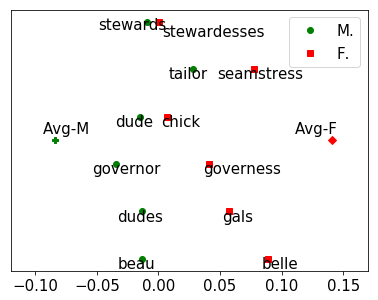

In [87]:
plot_titles_gd(es_ori_E, es_gender_pairs, [x[0] for x in m_f_w], [x[1] for x in m_f_w])
# plot_titles_gd(es_ali_E, es_gender_pairs, [x[0] for x in m_f_w], [x[1] for x in m_f_w])
# plot_titles_gd(es_sup_de_E, es_gender_pairs, [x[0] for x in m_f_w], [x[1] for x in m_f_w])
# plot_titles_gd(es_sup_endeb_E, es_gender_pairs, [x[0] for x in m_f_w], [x[1] for x in m_f_w])